# SERIES DE TIEMPO

- Importamos librerías necesarias:

In [1]:
import pandas as pd
from time import mktime
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import r2_score
import numpy as np
import itertools
from scipy import stats

## ANÁLISIS EXPLORATORIO DE LOS DATOS (EDA)

### Exploración de la muestra

In [5]:
data=pd.read_csv("C:/python_venv/TALENTO_B_2024/docs/stock_prices.csv")
data.head()

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
0,31/01/2000,110.803416,145.164513,89.967127,118.248015,116.158290,120.5747161
1,29/02/2000,110.011215,141.063683,92.335263,118.099936,127.103232,118.7053973
2,31/03/2000,112.395186,140.098690,91.217360,122.760796,124.294925,116.1646848
3,30/04/2000,113.591294,142.897176,91.945546,122.204326,132.652738,109.7337153
4,31/05/2000,113.981886,144.676906,89.175749,120.214614,129.143308,106.8073844


La muestra cuenta con 286 registros y 7 columnas:

In [7]:
data.columns

Index(['Date', 'Stock1', 'Stock2', 'Stock3', 'Stock4', 'Stock5', 'Stock6'], dtype='object')

In [6]:
data.shape

(286, 7)

Los registros de los precios para cada stock fueron tomados el último día de cada mes desde el 31 de enero del 2000 hasta el 31 de octubre del año actual 2023 

In [8]:
data[-1:]

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
285,31/10/2023,121.825782,154.339357,177.925534,239.392154,368.286726,244.9508893


### Verificación de datos faltantes

Se procede a realizar la verificación de datos faltantes en la muestra:

In [9]:
missing_data = data.isnull().sum()
print(missing_data)

Date      0
Stock1    1
Stock2    1
Stock3    0
Stock4    0
Stock5    0
Stock6    0
dtype: int64


Se encontraron dos datos faltantes en la muestra, especificamente en las columnas **stock1** y **stock2**, es necesario realizar una apropiada imputación de estos datos faltantes, para ello, se verificará primero cuales son exactamente estos registros faltantes:

In [58]:
missing1=data[data["Stock1"].isnull()]
missing1

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
79,31/08/2006,NaN,129.333046,93.113845,136.536229,176.670296,149.809895


In [60]:
missing2=data[data["Stock2"].isnull()]
missing2

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
170,31/03/2014,122.471407,NaN,102.369223,152.621697,304.850099,141.7556691


### Imputación de datos faltantes

### Análisis descriptivo

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Stock1,285.0,119.021446,6.330956,107.912490,113.685175,119.361852,123.804605,130.289727
Stock2,285.0,143.091340,11.699775,117.011712,134.412267,141.251579,153.666690,169.938853
Stock3,286.0,113.071234,29.419418,79.948564,89.375663,98.082476,142.054831,215.492450
Stock4,286.0,153.386488,37.291854,98.881841,123.342167,147.936460,166.906185,259.633973
Stock5,286.0,232.467520,61.283221,116.158290,177.933480,241.293273,278.979693,386.009285


- **stock1** : Esta acción cuenta con un precio promedio de 119.02 aproximadamente, con una desviación estandar de 6.330. hay 285 registros y un dato faltante. el 50% de los precios registrados para esta acción están por encima de 119.36

- **stock2** : Esta acción cuenta con un precio promedio de 143.091 con una desviación estándar de 11.699. desde el 2000 hasta el 2023 se han encontrado registros de precios mínimo de 117.01 y máximo 169.93.

- **stocks 3, 4 y 5** :  No se encontraron registros faltantes. Las tres acciones cuentan con registros de precios máximo sobre los 200, siendo el stock5 auqella con el mayor valor alcanzado, de 386.00. En general, el stock5 tiene el precio promedio más alto, aproximadamente de 232.46 con una desviación estándar de 61.28.

### Serie de tiempo: Tendencia y estacionariedad

Una operación fundamental para entender el comportamiento de una serie de tiempo y poder determinar si se trata de una serie estacionaria o no; es realizar gráficos de la misma.

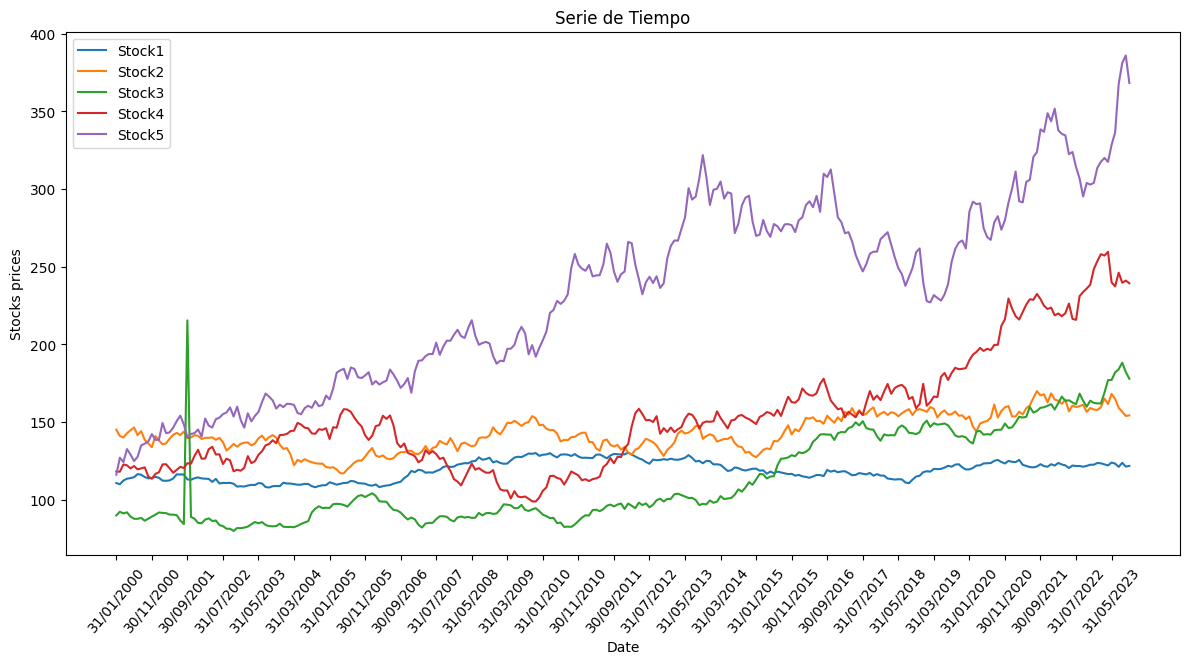

In [45]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data=data, x="Date", y=data["Stock1"], label="Stock1" )
ax1 = sns.lineplot(data=data, x="Date", y=data["Stock2"],label="Stock2")
ax2 = sns.lineplot(data=data, x="Date", y=data["Stock3"], label="Stock3")
ax3 = sns.lineplot(data=data, x="Date", y=data["Stock4"], label="Stock4")
ax4 = sns.lineplot(data=data, x="Date", y=data["Stock5"], label="Stock5")
freq = int(10)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
plt.tight_layout()
plt.title("Serie de Tiempo")
plt.ylabel('Stocks prices')
plt.xticks(rotation=50);

De la figura anterior, podemos ver la ausencia de estacionariedad en las series de tiempo.sin embargo se realizará la prueba ADF para verificar dicha hipótesis. 

- Ho: No estacionariedad

- H1: Estacionariedad

In [49]:
def prueba(stock):
    result = adfuller(stock)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [51]:
prueba(data["Stock3"])

ADF Statistic: 0.576606
p-value: 0.987025


In [61]:
prueba(data["Stock4"])

ADF Statistic: 0.115406
p-value: 0.967097


In [62]:
prueba(data["Stock5"])

ADF Statistic: -0.742085
p-value: 0.835545


Dado que el p-valor es mayor que el nivel de significancia (0.05), no se rechaza la hipótesis nula. Las series de tiempo son no estacionaria. 